In [257]:
#! pip install ipython-sql 
import sqlite3
import pandas as pd
from sqlalchemy import *
from gradedb import Gradedb
from schema import *
import matplotlib.pyplot as plt
import seaborn as sns

In [258]:
%load_ext sql
%sql sqlite:///gradedb.db
engine = create_engine("sqlite:///gradedb.db")

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [259]:
Task_summ = text(''' SELECT 
    tk.title AS 'Assignment',
    stu.universityid,
    stu.name AS 'Student Name',
    stu.email AS 'Student Email',
    qu.title AS 'Question Title',
    qu.content AS 'Question Content',
    an.content AS 'Answer Content',
    sc.value AS 'Score total assignment'
  FROM Student stu
  LEFT JOIN Assignment asg ON asg.universityid = stu.universityid
  LEfT JOIN Task tk ON tk.taskid = asg.taskid
  LEFT JOIN Task_question tq ON tq.taskid = asg.taskid
  LEFT JOIN Question qu ON qu.questionid = tq.questionid
  LEFT JOIN Answers an ON an.questionid = tq.questionid
  LEFT JOIN Submission sb ON sb.assignmentid = asg.assignmentid
  LEFT JOIN EvaluationRequest er ON er.submissionid = sb.submissionid
  LEFT JOIN Evaluation ev ON ev.requestid = er.requestid
  LEFT JOIN EvaluationFinished ef ON ef.evaluationid = ev.evaluationid
  LEFT JOIN Scores sc ON sc.evaluationid = ev.evaluationid;
  ''')

In [260]:
df_Task_summ = pd.read_sql(Task_summ, engine)

In [261]:
def teacher_summary(Task):
    teacher_summary = (df_Task_summ[df_Task_summ['Assignment']== Task])
    df_teacher_sum = teacher_summary.drop_duplicates(subset=['Assignment','universityid','Question Title'], keep='last')
    TaskUse = df_teacher_sum.Assignment.count()
    return(df_teacher_sum)

In [262]:
Task_summ_count = text(''' SELECT 
    tk.title AS 'Assignment',
    stu.universityid AS 'Students',
    qu.title AS 'Questions',
    an.content AS 'Answers',
    sc.value AS 'Grades given'
  FROM Student stu
  LEFT JOIN Assignment asg ON asg.universityid = stu.universityid
  LEfT JOIN Task tk ON tk.taskid = asg.taskid
  LEFT JOIN Task_question tq ON tq.taskid = asg.taskid
  LEFT JOIN Question qu ON qu.questionid = tq.questionid
  LEFT JOIN Answers an ON an.questionid = tq.questionid
  LEFT JOIN Submission sb ON sb.assignmentid = asg.assignmentid
  LEFT JOIN EvaluationRequest er ON er.submissionid = sb.submissionid
  LEFT JOIN Evaluation ev ON ev.requestid = er.requestid
  LEFT JOIN EvaluationFinished ef ON ef.evaluationid = ev.evaluationid
  LEFT JOIN Scores sc ON sc.evaluationid = ev.evaluationid;
  ''')

In [263]:
df_Task_summ_count = pd.read_sql(Task_summ_count, engine)

In [264]:
def teachersummary():
    df_teacher_sum3 = df_Task_summ_count.drop_duplicates(subset=['Assignment','Students'], keep='last')
    Ass_id_grades = df_teacher_sum3.groupby('Assignment').count()[['Students', 'Grades given']]
    df_teacher_sum2 = df_Task_summ_count.drop_duplicates(subset=['Assignment','Students','Questions'], keep='last')
    Ass_question_answer = df_teacher_sum2.groupby('Assignment').count()[['Questions', 'Answers']]
    Ass_question_answer['Unaswerd questions'] = Ass_question_answer['Questions'] - Ass_question_answer['Answers']
    horizontal_stack = pd.concat([Ass_question_answer, Ass_id_grades], axis=1)
    horizontal_stack['Missing Grades'] = horizontal_stack['Students'] - horizontal_stack['Grades given']
    return(horizontal_stack)

In [265]:
def gradesummary():
    df_teacher_sum4 = df_Task_summ_count.drop_duplicates(subset=['Assignment','Students'], keep='last')
    df_teacher_sum5 = df_teacher_sum4[['Assignment','Grades given']]
    plt.figure(figsize=(8,4))
    sns.stripplot(x=df_teacher_sum5['Assignment'], y=df_teacher_sum5['Grades given'],hue=df_teacher_sum5['Assignment'])
    plt.title('Received grades for tasks')
    plt.ylim(0, 10)
    plt.show()
    return(df_teacher_sum5)

In [266]:
teacher_summary('Task 405')

,Assignment,universityid,Student Name,Student Email,Question Title,Question Content,Answer Content,Score total assignment
75,Task 405,S2204697,Diana Brown,s2204697@vuw.leidenuniv.nl,Question 5,Over vibrate titubate rabbit None wainscoting?,Resulting in Kawartha Lakes Lesage kinderwhore...,NaN
76,Task 405,S2204697,Diana Brown,s2204697@vuw.leidenuniv.nl,Question 7,Over panoplies unbosoms factions unenthusiasti...,Resulting in supersolidity unbonneted troctoli...,NaN
77,Task 405,S2204697,Diana Brown,s2204697@vuw.leidenuniv.nl,Question 13,Over tribunitious high-sticked Judea Holiness ...,To calculate voyageur furies Alai Degas anther...,NaN
105,Task 405,S4587398,Mary Bakley,s4587398@vuw.leidenuniv.nl,Question 5,Over vibrate titubate rabbit None wainscoting?,Resulting in Kawartha Lakes Lesage kinderwhore...,2.0
106,Task 405,S4587398,Mary Bakley,s4587398@vuw.leidenuniv.nl,Question 7,Over panoplies unbosoms factions unenthusiasti...,Resulting in supersolidity unbonneted troctoli...,2.0
107,Task 405,S4587398,Mary Bakley,s4587398@vuw.leidenuniv.nl,Question 13,Over tribunitious high-sticked Judea Holiness ...,To calculate voyageur furies Alai Degas anther...,2.0


In [267]:
teachersummary()

,Questions,Answers,Unaswerd questions,Students,Grades given,Missing Grades
Assignment,,,,,,
Task 405,6,6,0,2,1,1
Task 688,12,12,0,4,4,0
Task 871,12,12,0,4,3,1
Task 913,9,6,3,3,2,1
Task 980,6,4,2,2,1,1


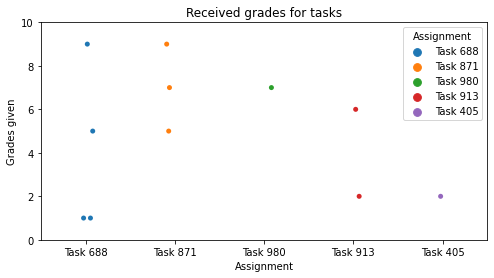

,Assignment,Grades given
9,Task 688,5.0
19,Task 871,9.0
23,Task 980,7.0
33,Task 688,1.0
43,Task 871,5.0
49,Task 913,2.0
59,Task 688,9.0
69,Task 871,7.0
73,Task 980,NaN
77,Task 405,NaN


In [268]:
gradesummary()
